In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
dataset_path = 'Garbage classification/Garbage classification'

classes = os.listdir(dataset_path)
print("Classes :",classes)

Classes : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
# Lets find the no of images in each classes 
for cls in classes:
    directory = os.path.join(dataset_path,cls)
    print(f'Images of Class "{cls}":\t {len(os.listdir(directory))}')

Images of Class "cardboard":	 403
Images of Class "glass":	 501
Images of Class "metal":	 410
Images of Class "paper":	 594
Images of Class "plastic":	 482
Images of Class "trash":	 137


In [8]:
# lets find the image qulaity 
widths, heights, channels = [],[],[]

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path,cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path,img_name)
            try:
                img = Image.open(img_path)
                w,h = img.size
                widths.append(w)
                heights.append(h)
                channels.append(len(img.getbands()))
            except:
                pass
    
mean_w, mean_h = np.mean(widths), np.mean(heights)
std_w, std_h = np.std(widths), np.std(heights)
unique_channels = set(channels)

# Display summary table
summary = pd.DataFrame({
    "Mean Width": [round(mean_w, 2)],
    "Mean Height": [round(mean_h, 2)],
    "Std Width": [round(std_w, 2)],
    "Std Height": [round(std_h, 2)],
    "Color Channels": [unique_channels]
})
summary
                

Mean Width  Mean Height  Std Width  Std Height Color Channels
0       512.0        384.0        0.0         0.0            {3}

In [10]:
# lets check the size of individual image 

directory = os.path.join(dataset_path, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

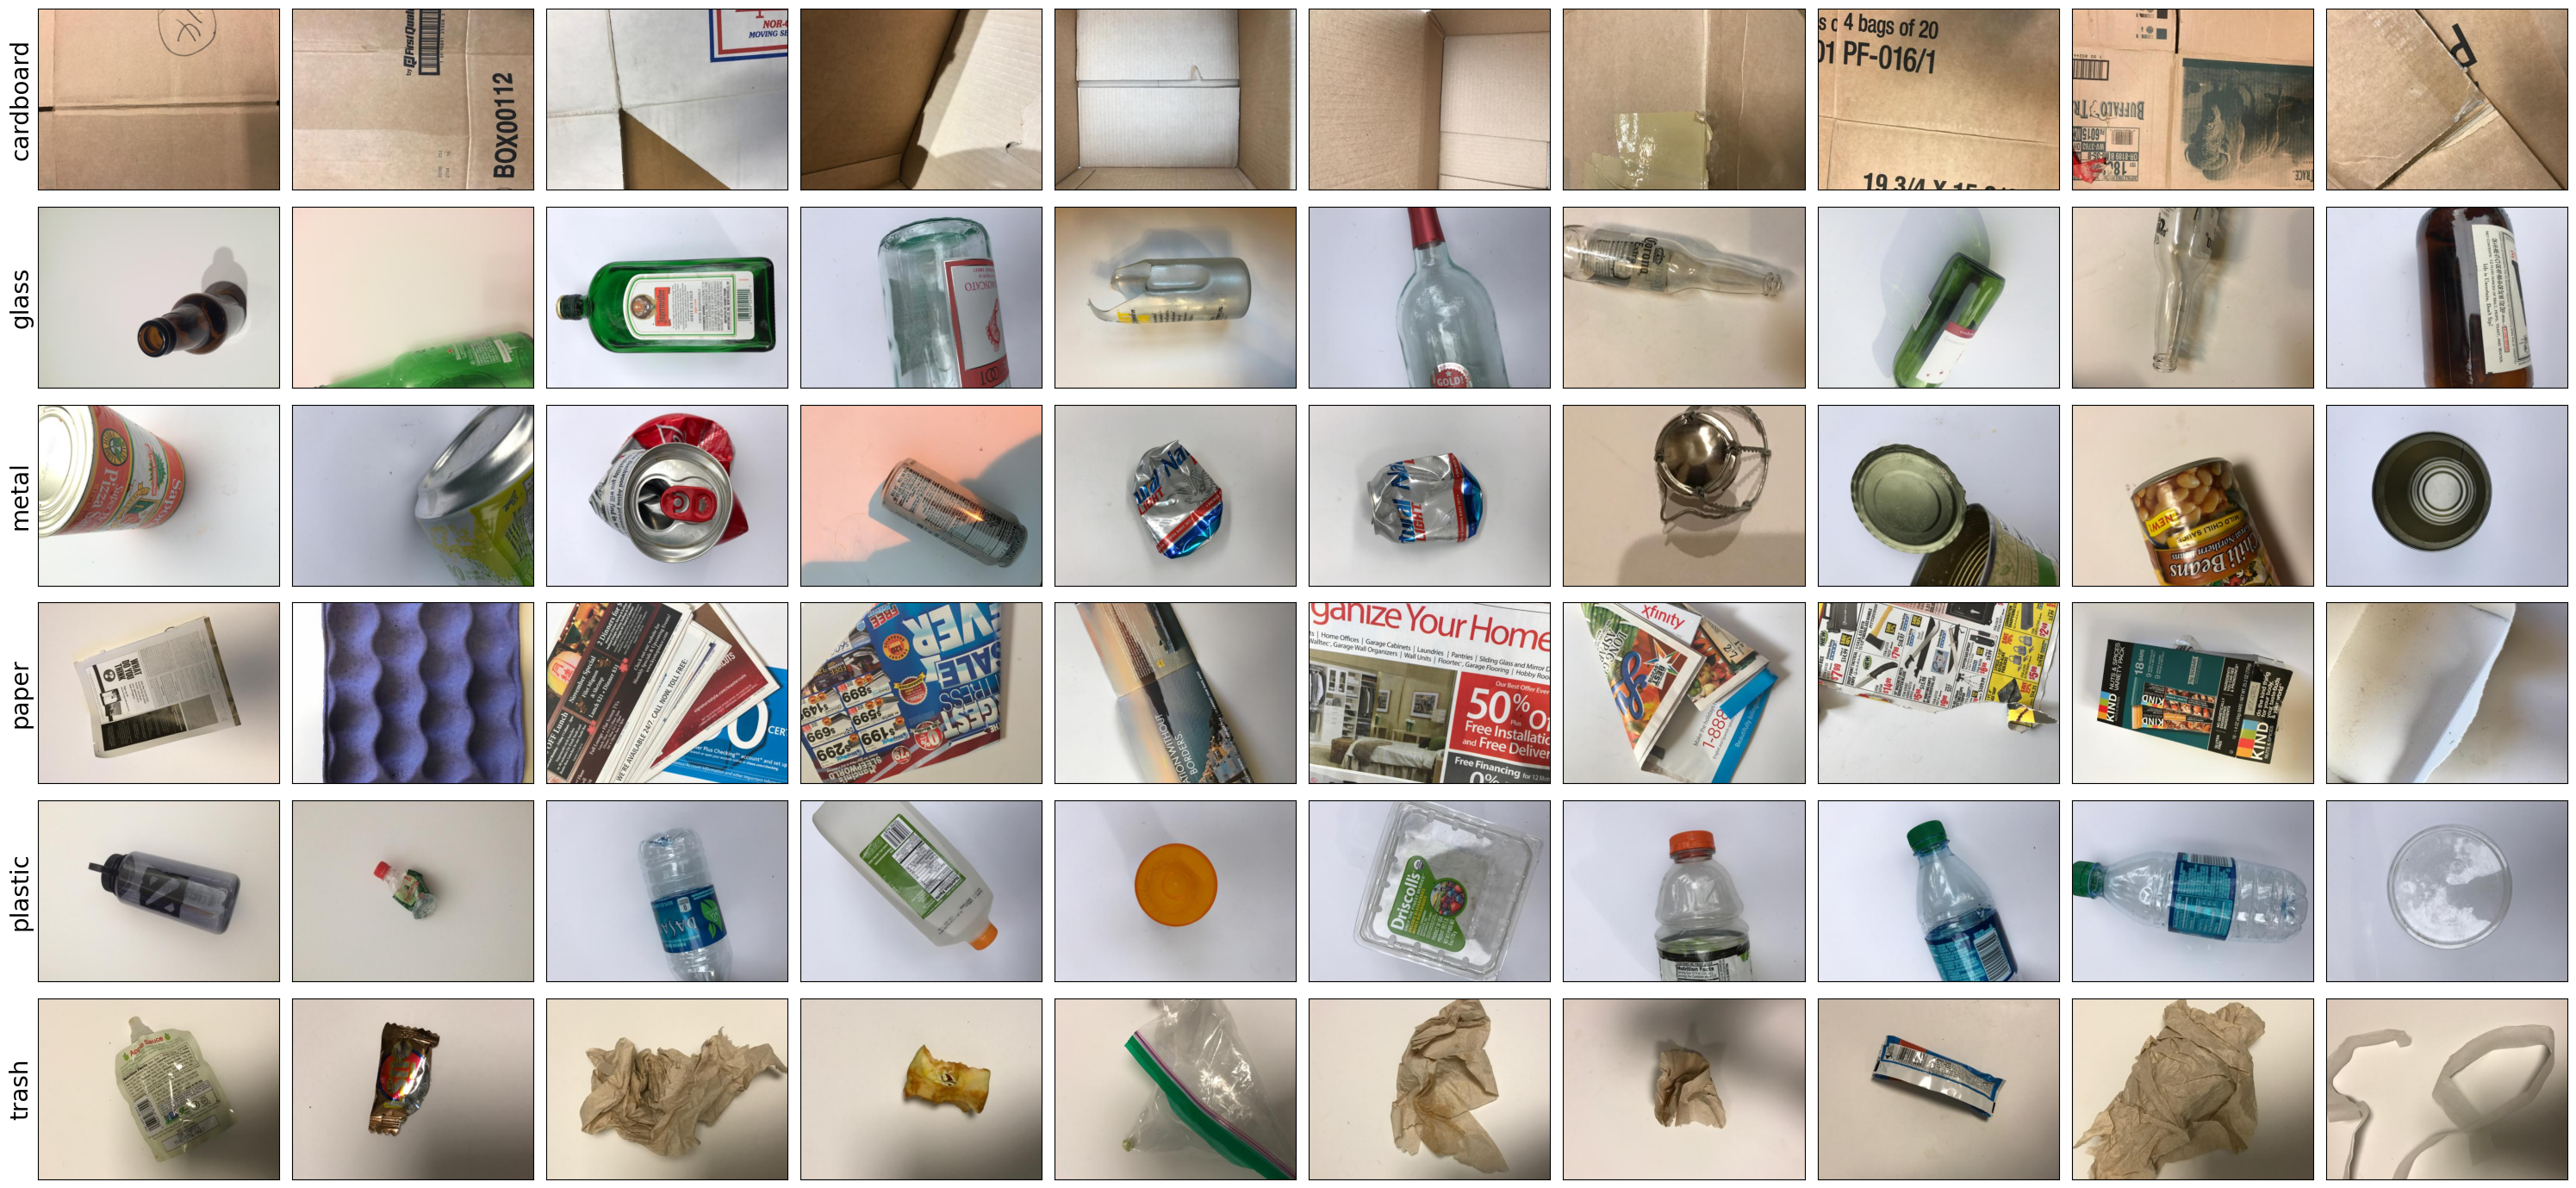

In [12]:
# lets understand the dataset 
plt.figure(figsize=(30,14))

for i in range(6):
    directory = os.path.join(dataset_path, classes[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(classes[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [14]:
# Splitting Dataset automatically using flow_from_directory

train_datagen = ImageDataGenerator(horizontal_flip= True, vertical_flip= True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255.,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(dataset_path,
target_size=(224,224),batch_size=32, class_mode='categorical',subset='training')
validation_generator= train_datagen.flow_from_directory(dataset_path,
target_size=(224,224),batch_size=32, class_mode='categorical',subset='validation')



Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [16]:
# Model Building 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,316,102 (69.87 MB)

 Trainable params: 16,058,118 (61.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

history = model.fit(train_generator, epochs=15, verbose=1, validation_data= validation_generator,
                    callbacks=[callbacks])


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
63/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.4566 - loss: 2.2386

16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step
              precision    recall  f1-score   support

   cardboard       0.12      0.10      0.11        80
       glass       0.17      0.22      0.19       100
       metal       0.12      0.15      0.13        82
       paper       0.18      0.19      0.18       118
     plastic       0.21      0.17      0.18        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.16       503
   macro avg       0.13      0.14      0.13       503
weighted avg       0.15      0.16      0.16       503



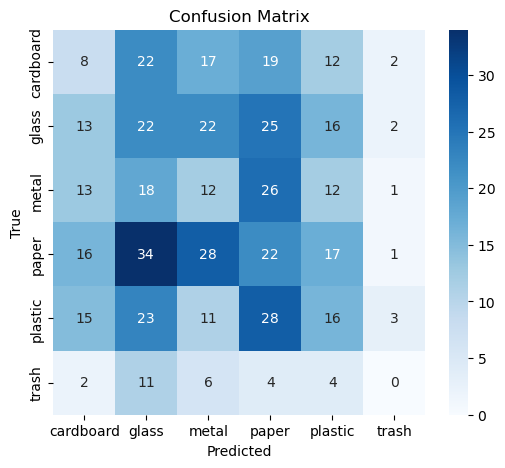

In [10]:
# Evaluating Model
val_preds = model.predict(validation_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = validation_generator.classes

print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys(),cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Saving Model 
os.makedirs('model',exist_ok=True)
model.save('model/garbage_classifier.keras')

print("Model Saved succesfullyz")

Model Saved succesfullyz
